# WYZWANIE: Klasyfikacja obrazów (patologii roślin)

## Załadowanie bibliotek

In [84]:
#%pip install livelossplot
import zipfile
import pandas as pd
import os 
import matplotlib.pyplot as plt
from get_image_size import get_image_size, UnknownImageFormat
from PIL import Image
import uuid
import hashlib
from tqdm import tqdm
import cv2
import plotly.express as px
import numpy as np
import shutil 
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
from livelossplot import PlotLossesKeras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

## Załadowanie plików

In [2]:
with zipfile.ZipFile('plant-pathology-2020-fgvc7.zip', 'r') as zip_ref:
    zip_ref.extractall(".")
IMAGES_PATH = "\\images"
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"
SAMPLE_SUBMISSION_CSV = "sample_submission.csv"

## Przygotowanie danych
### Eksploracja danych 
#### a) Wyświetlenie danych

In [3]:
test_data = pd.read_csv(TEST_CSV)
train_data = pd.read_csv(TRAIN_CSV)
sample_submission_data = pd.read_csv(SAMPLE_SUBMISSION_CSV)

In [4]:
test_data.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [5]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [6]:
sample_submission_data.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

#### b) Wyświetlenie podstawowych statystyk

In [7]:
sample_submission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image_id           1821 non-null   object 
 1   healthy            1821 non-null   float64
 2   multiple_diseases  1821 non-null   float64
 3   rust               1821 non-null   float64
 4   scab               1821 non-null   float64
dtypes: float64(4), object(1)
memory usage: 71.3+ KB


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB


In [10]:
test_data.describe().T

count unique        top freq
image_id  1821   1821  Test_1297    1

In [11]:
train_data.describe().T

count      mean       std  min  25%  50%  75%  max
healthy            1821.0  0.283361  0.450754  0.0  0.0  0.0  1.0  1.0
multiple_diseases  1821.0  0.049973  0.217948  0.0  0.0  0.0  0.0  1.0
rust               1821.0  0.341571  0.474367  0.0  0.0  0.0  1.0  1.0
scab               1821.0  0.325096  0.468539  0.0  0.0  0.0  1.0  1.0

In [12]:
y = train_data.drop('image_id', axis=1).values
X = train_data["image_id"]

In [13]:
class_names = {"1000":"healthy",
               "0100":"multiple_diseases",
               "0010": "rust",
               "0001": "scab"}
y = y.astype(str).tolist()
y = ["".join(x) for x in y]

In [14]:
labels = list(map(lambda x: class_names[x],y))
train_data["class"] = labels

In [15]:
train_data

image_id  healthy  multiple_diseases  rust  scab              class
0        Train_0        0                  0     0     1               scab
1        Train_1        0                  1     0     0  multiple_diseases
2        Train_2        1                  0     0     0            healthy
3        Train_3        0                  0     1     0               rust
4        Train_4        1                  0     0     0            healthy
...          ...      ...                ...   ...   ...                ...
1816  Train_1816        0                  0     0     1               scab
1817  Train_1817        1                  0     0     0            healthy
1818  Train_1818        1                  0     0     0            healthy
1819  Train_1819        0                  0     1     0               rust
1820  Train_1820        0                  0     0     1               scab

[1821 rows x 6 columns]

In [16]:
train_dir = os.path.join("images",'train')
test_dir = os.path.join("images",'test')
valid_dir = os.path.join("images",'valid')
list_dir = [train_dir,test_dir,valid_dir]

In [17]:
for dir_name in list_dir:
    shutil.rmtree(dir_name,ignore_errors=True)
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [18]:
size_map = {}
error_path = []
for file in os.listdir("images"):
    file = f'images/{file}'
    if ".jpg" not in file:
        continue
    try:
        width, height = get_image_size(file)
    except UnknownImageFormat as e:
        error_path.append(file)
        continue
    size_key = f"{width}x{height}"
    if size_key in size_map:
        size_map[size_key].append(file)
    else:
        size_map[size_key] = [file]

In [19]:
possible_dupl = [size for size in size_map if len(size_map[size]) > 1]

In [20]:
def calculate_image_hash(file_path):
    if os.path.isfile(file_path):
        im = Image.open(file_path)
        return hashlib.md5(im.tobytes()).hexdigest()
    else:
        return str(uuid.uuid4())

In [21]:
for idx, dupl in enumerate(possible_dupl):
    list_files = size_map[dupl]
    tqdm.pandas(desc=f"process dupl {idx}/{len(possible_dupl)}")
    df = pd.DataFrame(list_files, columns=["file_path"])
    df["signature"] = df["file_path"].progress_apply(lambda x: calculate_image_hash(x))
    group_series = list(df.groupby("signature")["file_path"].apply(list).values)
    for group in group_series:
        if len(group) > 1:
            print(group)

process dupl 1/2:  14%|████████▊                                                        | 3/22 [00:00<00:00, 21.03it/s]

['images/Test_1407.jpg', 'images/Train_1703.jpg']
['images/Test_1212.jpg', 'images/Test_570.jpg']
['images/Test_1691.jpg', 'images/Test_683.jpg']
['images/Test_829.jpg', 'images/Train_1505.jpg']
['images/Train_1173.jpg', 'images/Train_379.jpg']


process dupl 1/2: 100%|████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.96it/s]


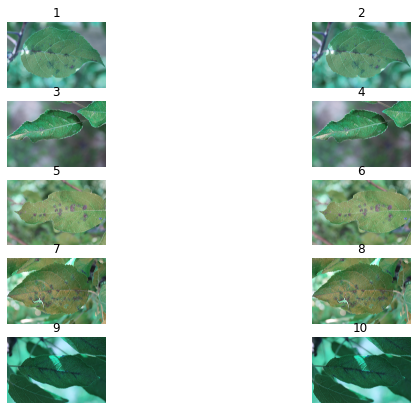

In [22]:
fig = plt.figure(figsize=(10, 7))
img_compare1 = ['images/Test_1407.jpg', 'images/Train_1703.jpg']
img_compare2 = ['images/Test_1212.jpg', 'images/Test_570.jpg']
img_compare3 = ['images/Test_1691.jpg', 'images/Test_683.jpg']
img_compare4 =['images/Test_829.jpg', 'images/Train_1505.jpg']
img_compare5 = ['images/Train_1173.jpg', 'images/Train_379.jpg']
# setting values to rows and column variables
rows = 5
columns = 2
  
# reading images
Image1 = cv2.imread(img_compare1[0])
Image2 = cv2.imread(img_compare1[1])
Image3 = cv2.imread(img_compare2[0])
Image4 = cv2.imread(img_compare2[1])
Image5 = cv2.imread(img_compare3[0])
Image6 = cv2.imread(img_compare3[1])
Image7 = cv2.imread(img_compare4[0])
Image8 = cv2.imread(img_compare4[1])
Image9 = cv2.imread(img_compare5[0])
Image10 = cv2.imread(img_compare5[1])

list_img = [Image1,Image2,Image3,Image4,Image5,Image6,Image7,Image8,Image9,Image10]
for idx, element in enumerate(list_img):
    fig.add_subplot(rows, columns, idx+1)
    plt.imshow(element)
    plt.axis('off')
    plt.title(f'{idx+1}')
    

In [23]:
img_comp0 = img_compare5[0].split('.')[0].split("/")[1]
img_comp1 = img_compare5[1].split('.')[0].split("/")[1]
train_data.loc[(train_data["image_id"] == img_comp0) | (train_data["image_id"] == img_comp1)]

image_id  healthy  multiple_diseases  rust  scab              class
379    Train_379        0                  0     0     1               scab
1173  Train_1173        0                  1     0     0  multiple_diseases

In [24]:
to_delete_img = ["images/Test_1407.jpg","images/Test_1212.jpg","images/Test_1691.jpg","images/Test_829.jpg",img_compare5[0],img_compare5[1]]

In [25]:
for file in to_delete_img:
    os.remove(file)

In [26]:
for class_name in class_names.values():
    class_path_train = os.path.join(train_dir,class_name)
    class_path_valid = os.path.join(valid_dir,class_name)
    if not os.path.exists(class_path_train):
        os.mkdir(class_path_train)
    if not os.path.exists(class_path_valid):
        os.mkdir(class_path_valid)

In [27]:
train_data_groupby = train_data.groupby("class")["image_id"].apply(list)

In [28]:
sum_train_data = train_data_groupby.apply(len)

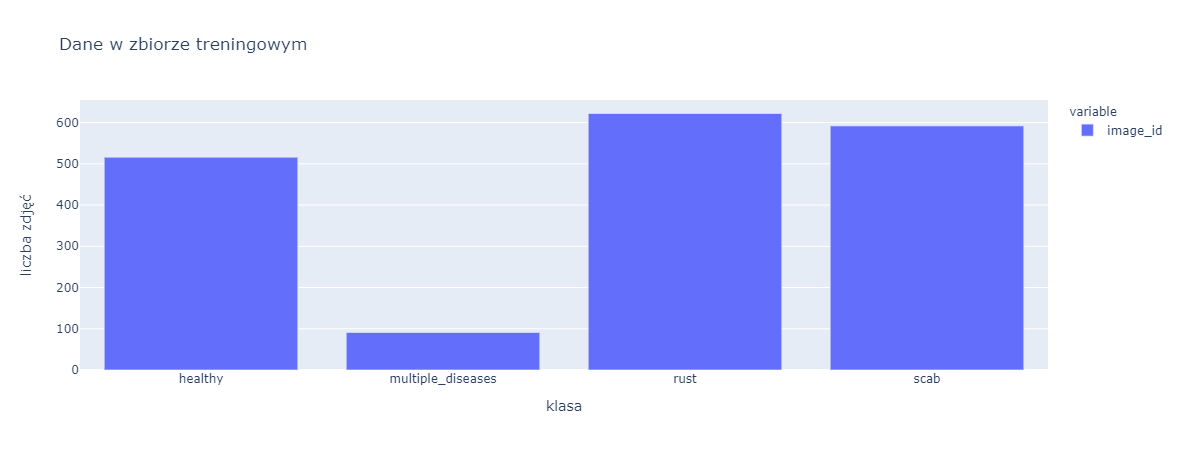

In [29]:
fig = px.bar(sum_train_data, title="Dane w zbiorze treningowym",labels={"value": "liczba zdjęć",
                                                                       "class": "klasa"})
fig.show()

Powyżej wyświetlono liczebność danych w klasach. Widać, że klasa multiple_diseases odstaje względem innych klas - w tym przypadku mamy do czynienia z niezrównoważonym zbiorem danych. 

In [30]:
for class_name,value in train_data_groupby.items():
    np.random.shuffle(train_data_groupby[class_name])

In [31]:
validation_ratio = 0.2

train_filenames = {}
val_filenames = {}

for class_name,value in train_data_groupby.items():
    value_photos = sum_train_data[class_name]
    train_idx = int(value_photos * (1-(validation_ratio)))
    train_filenames[class_name] = train_data_groupby[class_name][:train_idx]
    val_filenames[class_name] = train_data_groupby[class_name][train_idx:]

In [32]:
old_dir = f'{os.getcwd()}/images'
for class_name, files in train_filenames.items():
    for file in files:
        file = file + ".jpg"
        try:
            shutil.move(f"{old_dir}/{file}",f"{old_dir}/train/{class_name}/{file}")
        except FileNotFoundError as e:
            print(e)
            pass

[Errno 2] No such file or directory: 'D:\\Dropbox\\Agusi\\Staż\\Assecco\\Plant/images/Train_1173.jpg'
[Errno 2] No such file or directory: 'D:\\Dropbox\\Agusi\\Staż\\Assecco\\Plant/images/Train_379.jpg'


In [33]:
for class_name, files in val_filenames.items():
    for file in files:
        file = file + ".jpg"
        try:
            shutil.move(f"{old_dir}/{file}",f"{old_dir}/valid/{class_name}/{file}")
        except FileNotFoundError as e:
            #print(e)
            pass

In [34]:
for file in os.listdir(old_dir):
    if ".jpg" in file:
        try:
            shutil.move(f"{old_dir}/{file}",f"{old_dir}/test/{file}")
        except FileNotFoundError as e:
            print(e)
            pass

In [35]:

train_dir = os.path.join(old_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(old_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(old_dir, 'test')      # katalog zbioru testowego

train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)


valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 1452 images belonging to 4 classes.
Found 367 images belonging to 4 classes.


In [36]:
def display_augmented_images(directory, idx):

    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

# Przykład augumentacji danych

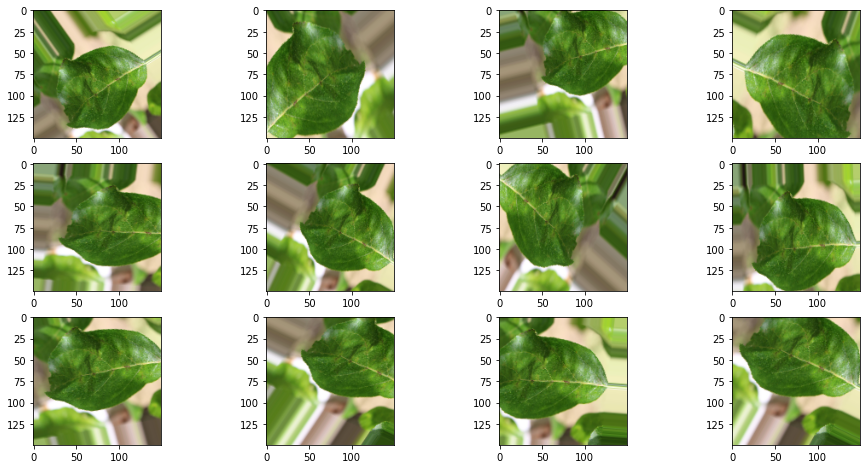

In [46]:

idx = 3           
display_augmented_images(f'{train_dir}\scab', idx)

In [38]:
def list_files(base_path):
    count = 0 
    for depth_1 in os.listdir(base_path):
        depth_1_path = f"{base_path}/{depth_1}"
        count += len(os.listdir(depth_1_path))
    return count

In [39]:
train_size = list_files(train_dir)
valid_size = list_files(valid_dir)
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [40]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [41]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [42]:

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 22,122,820
Trainable params: 11,537,668
Non-trainable params: 10,585,152
_________________________________________________________________


D:\Anaconda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



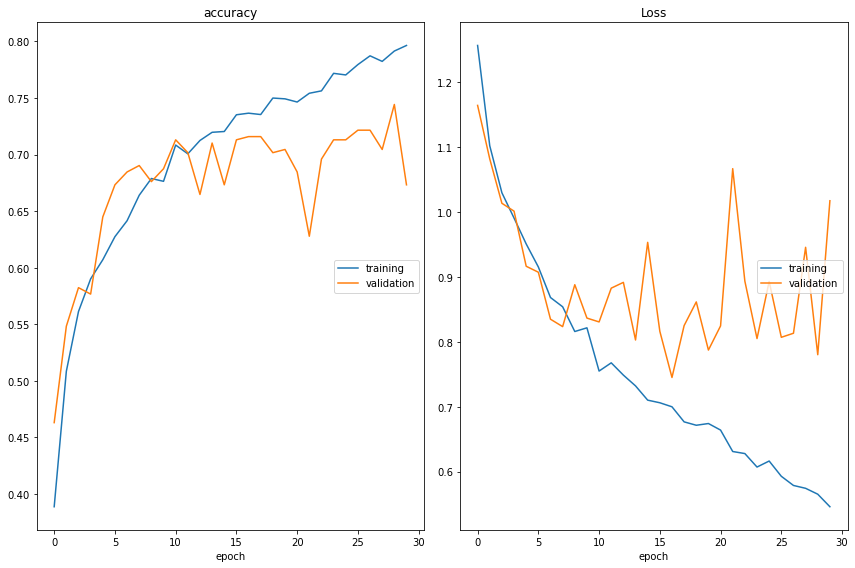

accuracy
	training         	 (min:    0.389, max:    0.796, cur:    0.796)
	validation       	 (min:    0.463, max:    0.744, cur:    0.673)
Loss
	training         	 (min:    0.546, max:    1.257, cur:    0.546)
	validation       	 (min:    0.745, max:    1.164, cur:    1.018)


In [43]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                              callbacks=[PlotLossesKeras()],
                             validation_steps=validation_steps)

In [44]:
import pickle
pickle.dump( history.history, open( "history.p", "wb" ) )

In [45]:
model.save("model.h5")

In [77]:
def prepare_dataset(directory=valid_dir):
        return tf.keras.preprocessing.image_dataset_from_directory(
          directory,
          label_mode="categorical",
          image_size=(150, 150),
          batch_size=1)

In [87]:
def cm(test_ds,new_model,plot_file,class_names):
    i = 0 
    y_pred = []
    y_true = []
    for image, label in test_ds.take(len(test_ds)):
        y_true.append(class_names[np.argmax(label[0])])
        image = image[0, :, :, :]
        prediction_scores = new_model.predict(np.expand_dims(image, axis=0))
        y_pred.append(class_names[np.argmax(prediction_scores)])
        i += 1
    fig = plt.figure(figsize=(20,20))
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots()
    cmd.plot(ax=ax)
    fig.set_size_inches(20,20)
    Path("plots").mkdir(parents=True,exist_ok=True)
    fig.savefig(f"plots/{plot_file}")
    return y_pred,y_true

In [78]:
valid_ds = prepare_dataset()

Found 367 files belonging to 4 classes.


<Figure size 1440x1440 with 0 Axes>

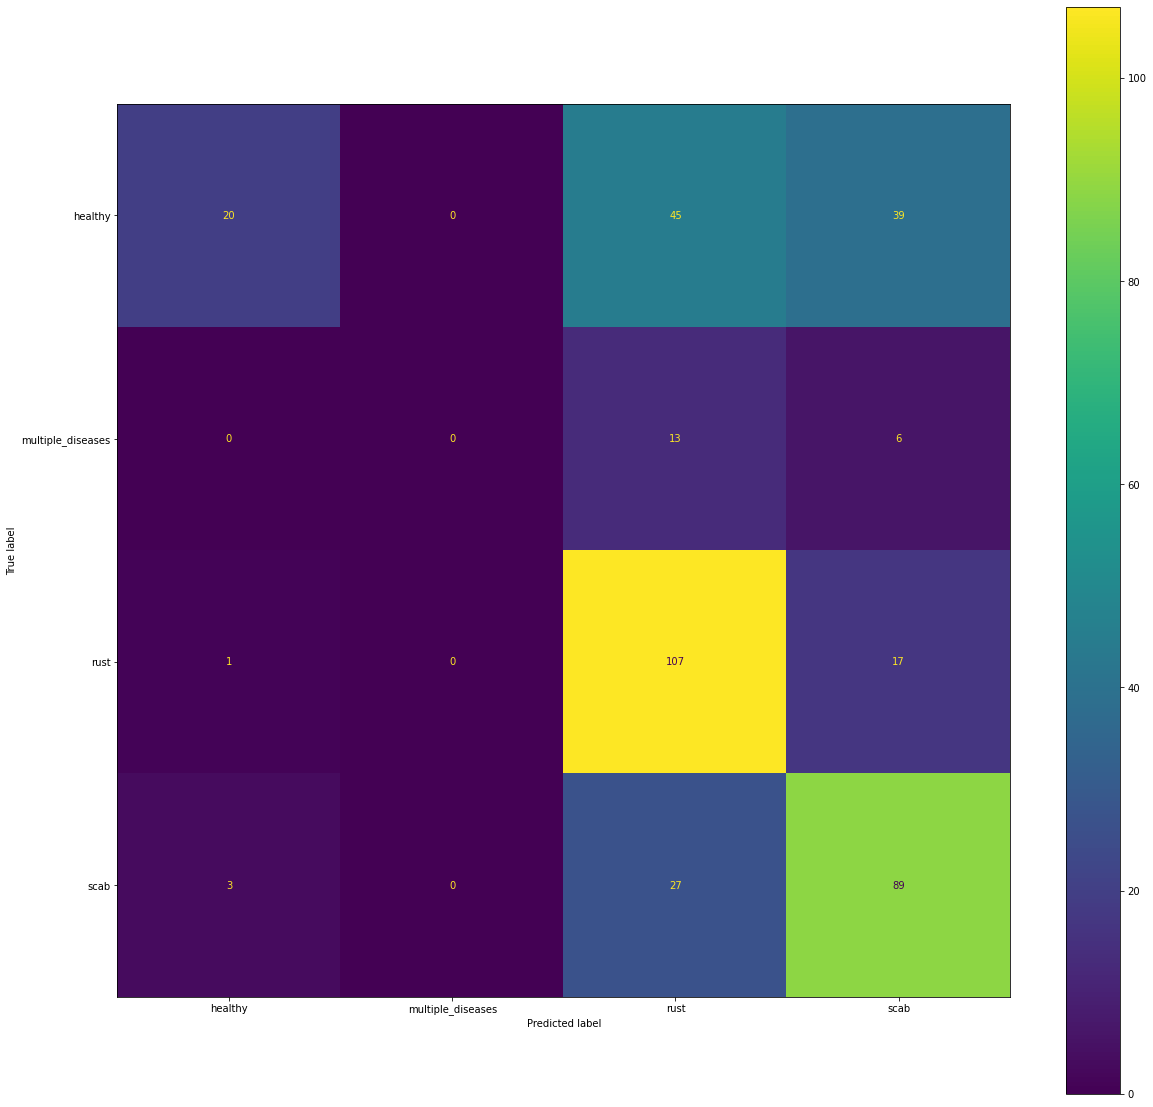

In [88]:
y_pred, y_true = cm(valid_ds,model,"plot.png",list(class_names.values()))

In [129]:
from sklearn.metrics import f1_score, recall_score
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred,average="weighted")

print(f"f1: {f1},\nrecall: {recall}")

f1: 0.5322526155204792,
recall: 0.5885558583106267


Im większe F1 score - tym lepiej dla modelu. W macierzy pomyłek można zauważyć, że w przypadku dwóch schorzeń - model popełnia znaczące błędy. Ponadto metryki recall oraz precision nie świadczą zbyt dobrze o modelu. 

W celu polepszenia modelu: 
- Na pewno należałoby skorzystać z lepszego modelu do transfer learning,
- Należałoby dodać inną augumentację danych, 
- ponadto tak jak wcześniej zostało wspomniane, należałoby skupić się na zrównoważeniu danych, ponieważ jedna z klas jest o wiele mniej liczna niż pozostałe. 
